### Importing libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.tokenize import sent_tokenize,word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OneHotEncoder
import spacy
import tensorflow
from keras.optimizers import Adam
from tensorflow.python.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,LSTM,Bidirectional,Activation,GRU,Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
nlp=spacy.load('en_core_web_sm')
import warnings
warnings.filterwarnings

<function warnings.filterwarnings(action, message='', category=<class 'Warning'>, module='', lineno=0, append=False)>

### Loading the dataset

In [3]:
data=pd.read_csv('drive/My Drive/Colab Notebooks/IMDB_Dataset.csv')

In [4]:
data

review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]

In [5]:
data.shape

(50000, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
data.describe()

review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

<Axes: xlabel='sentiment', ylabel='count'>

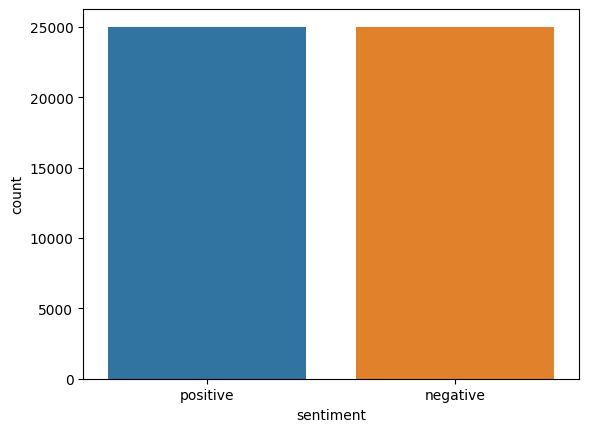

In [8]:
sns.countplot(x=data.sentiment,data=data)

In [9]:
print(data.sentiment.value_counts())

positive    25000
negative    25000
Name: sentiment, dtype: int64


# number of positive and negative sentiment are equal

In [10]:
data.sentiment=[1 if each=='positive' else 0 for each in data.sentiment]

In [11]:
data.head()

review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1

## Calculating the word frequencies

In [ ]:
def gen_freq(text):
  words_list=[]
  for word in text.split():
    words_list.extend(word)
  #Generating word frequences using value_counts in word-list
  word_freq=pd.Series(words_list).value_counts()
  word_freq[:100]#displaying top 100 words
  return word_freq

In [ ]:
freq=gen_freq(data.review.str)


In [ ]:
freq

the                568735
a                  306960
and                301919
of                 283625
to                 261850
                    ...  
"Mithi/Mithali"         1
(Konkona)               1
"Prof.Anu"              1
(Shabhana               1
Yosemite.<br            1
Length: 438729, dtype: int64

### Creating the Word Clouds

In [ ]:
from wordcloud import WordCloud

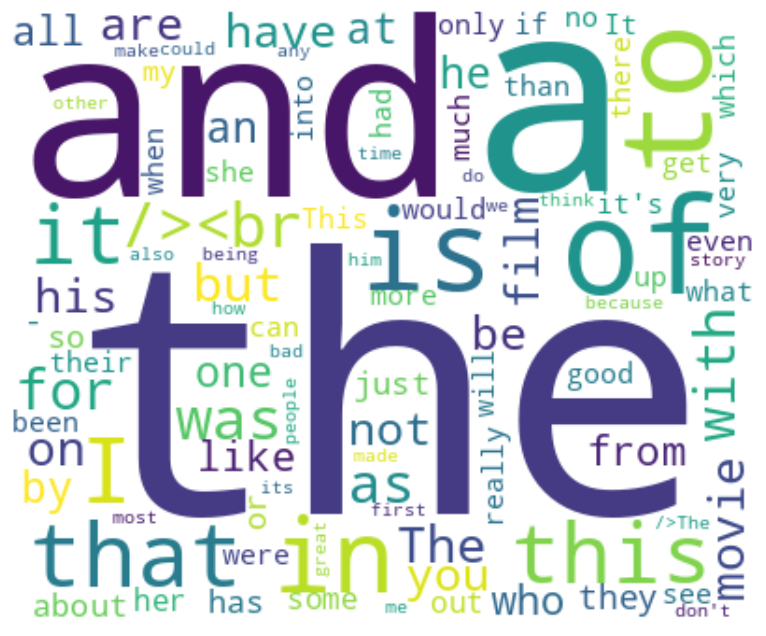

In [ ]:
#generating the wordcloud
wc=WordCloud(width=400,height=330,max_words=100,background_color='white').generate_from_frequencies(freq)
plt.figure(figsize=(14,8))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

## word cloud using positive reviews

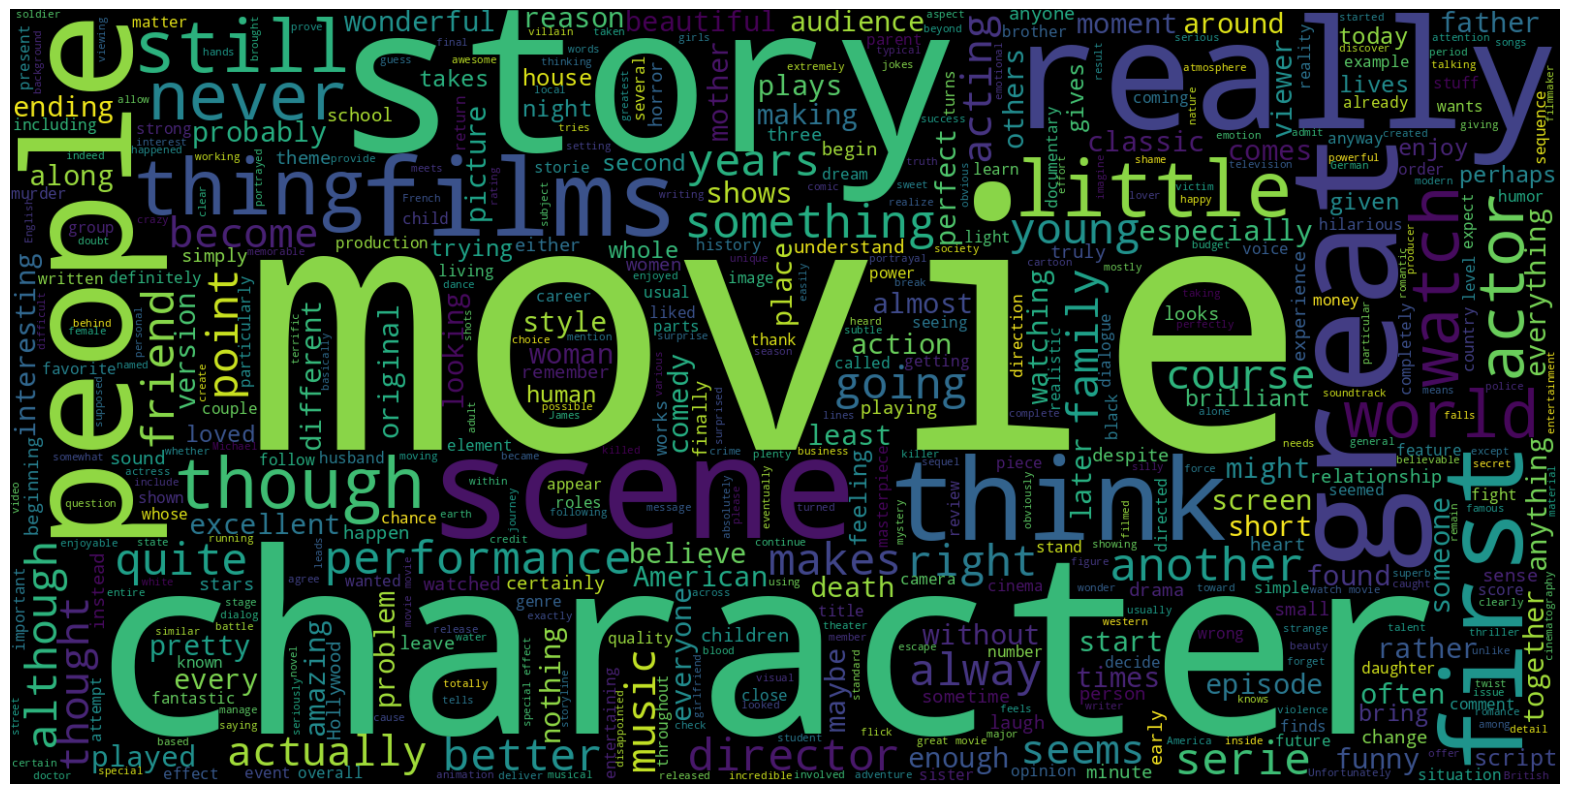

In [ ]:
plt.figure(figsize=(20,20))
Wc=WordCloud(max_words=500,width=1600,height=800,min_word_length=5).generate(" ".join(data[data.sentiment==1].review))
plt.axis('off')
plt.imshow(Wc,interpolation='bilinear')

## using negative reviews

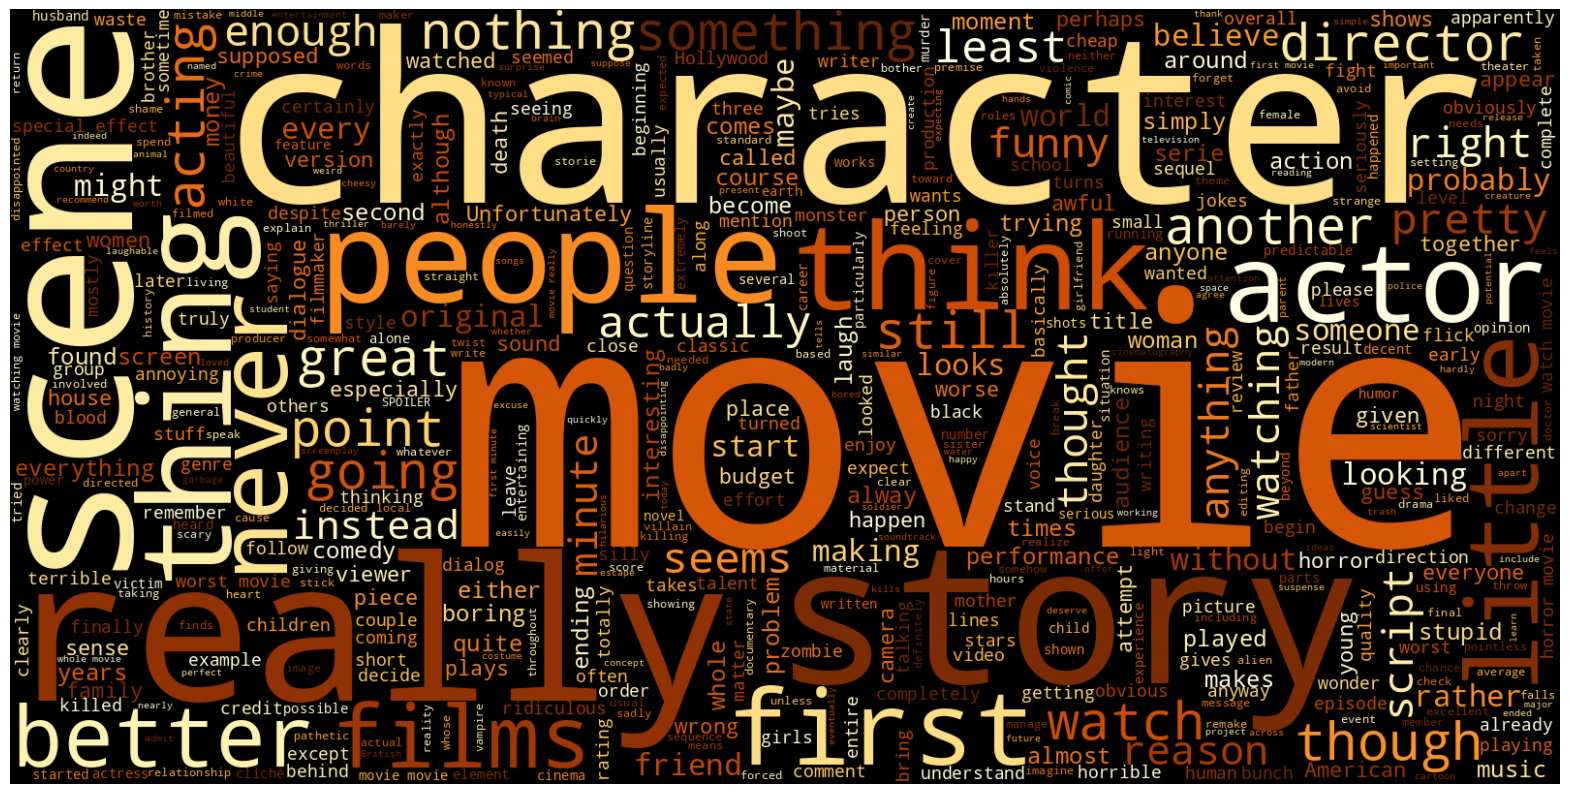

In [ ]:
plt.figure(figsize=(20,20))
WC=WordCloud(max_words=500,width=1600,height=800,min_word_length=5,colormap="YlOrBr").generate(" ".join(data[data.sentiment==0].review))
plt.axis('off')
plt.imshow(WC,interpolation='bilinear')

## Removing the html tags

In [12]:
def cleaner_text(text):
  #removing the html tags
  text=re.sub(r"<.*?>"," ",text)
  return text


In [13]:
data.review=data.review.apply(cleaner_text)

In [14]:
data.review[2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.  This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.  This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [15]:
data.review[7]

"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.  It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such brilliance and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a huge success. As it is now, the show is just awful. I can't believe it's still on the air."

## creating a dictionary in order to remove shortforms

In [16]:
dd={
    "I'D":'i had',
    "WOODY'S":'woodies',
    "THERE'S":'there is',
    "I'LL":'i will',
    "IT'S":'it is',
    "WHAT'S":'what is',
    "THEY'D":'they would',
    "I'VE":'i have',
    "I'M":'i am',
    "WE'LL":'we will',
    "YOU'LL":'you will',
    "U'LL":'you will',
    "COULDN'T":'could not',
    "SHOULDN'T":'should not',
    "WOULDN'T":'would not',
    "DIDN'T":'did not',
    "DON'T":'do not',
    "WON'T":'would not',
    "DOESN'T":'does not',
    "CAN'T":'cannot',
    "AREN'T":'are not',
    "WASN'T":'was not',
    "AIN'T":'is not',
    "ISN'T":'is not',
    'TKTS':'tickets',
    'USF':'useful',
    'C':'see',
    'U':'you',
    "'M":'am',
    "'VE":'have',
    "'LL":'will',
    "N'T":'not',
    "YOU'RE":'you are',
    '1':'one',
    '2':'two',
    '3':'three',
    '4':'four',
    '5':'five',
    '6':'six',
    '7':'seven',
    '8':'eight',
    '9':'nine',
    '10':'ten',
}

In [17]:
def chat_word(text):
    new_text=[]
    for word in text.split():
            if word.upper() in dd.keys():
                new_text.append(dd[word.upper()])
            else:
                new_text.append(word)
    return " ".join(new_text)


In [18]:
data.review=data.review.apply(chat_word)

In [19]:
data.review[6]

"I sure would like to see a resurrection of a up dated Seahunt series with the tech they have today it would bring back the kid excitement in me.I grew up on black and white TV and Seahunt with Gunsmoke were my hero's every week.You have my vote for a comeback of a new sea hunt.We need a change of pace in TV and this would work for a world of under water adventure.Oh by the way thank you for an outlet like this to view many viewpoints about TV and the many movies.So any ole way I believe i have got what I wanna say.Would be nice to read some more plus points about sea hunt.If my rhymes would be ten lines would you let me submit,or leave me out to be in doubt and have me to quit,If this is so then I must go so lets do it."

## Cleaning and removing Unwanted text

### removing the apstrophs 's

In [20]:
def remove_apstrophs(text):
  text=re.sub(r"'s",' ',text)
  return text

In [21]:
data.review=data.review.apply(remove_apstrophs)

In [22]:
data.review[4]

'Petter Mattei  "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. This being a variation on the Arthur Schnitzler  play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat. The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is the case with most of the people we enc

In [23]:
import string
punc=string.punctuation

In [24]:
punc

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Removing  the punctuation marks associated with the text

In [25]:
def remove_marks(text):
  text=re.sub(r"[!\"#$%&\\'()*+,-\.\/:;<=>\?\]\^_\`{\|}\]]+"," ",text)
  return text

In [26]:
data.review=data.review.apply(remove_marks)

In [27]:
data.review[2]

'I thought this was a wonderful way to spend time on a too hot summer weekend  sitting in the air conditioned theater and watching a light hearted comedy  The plot is simplistic  but the dialogue is witty and the characters are likable  even the well bread suspected serial killer  While some may be disappointed when they realize this is not Match Point 2  Risk Addiction  I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love  This was the most i had laughed at one of woodies comedies in years  dare I say a decade  While i have never been impressed with Scarlet Johanson  in this she managed to tone down her  sexy  image and jumped right into a average  but spirited young woman  This may not be the crown jewel of his career  but it was wittier than  Devil Wears Prada  and more interesting than  Superman  a great comedy to go see with friends '

### Removing stopwords and punctuations

In [28]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
from nltk.corpus import stopwords
stops=stopwords.words('english')

In [30]:
from nltk.tokenize import word_tokenize


In [31]:
def remove_stops(text):
  new_text=[]
  #converting the text into the lower-case
  text=text.lower()
  tokens=word_tokenize(text)
  for word in tokens:
    if word not in stops:
      new_text.append(word)
  return " ".join(new_text)


In [32]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [33]:
data.review=data.review.apply(remove_stops)

In [34]:
data.head()

review  sentiment
0  one reviewers mentioned watching one oz episod...          1
1  wonderful little production filming technique ...          1
2  thought wonderful way spend time hot summer we...          1
3  basically family little boy jake thinks zombie...          0
4  petter mattei love time money visually stunnin...          1

In [35]:
data.review[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point 2 risk addiction thought proof woody allen still fully control style many us grown love laughed one woodies comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends'

### Removing the digits

In [36]:
def remove_digits(text):
  text=re.sub(r"[0-9]+"," ",text)
  return text

In [37]:
data.review=data.review.apply(remove_digits)

In [38]:
data.review[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point   risk addiction thought proof woody allen still fully control style many us grown love laughed one woodies comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends'

## Lemmatization


In [39]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [40]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [41]:
nlp=spacy.load('en_core_web_sm')

In [42]:
def lemmatization(text):
  new_text=[]
  doc=nlp(text)
  for token in doc:
    new_text.append(token.lemma_)
  return " ".join(new_text)

In [43]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [44]:
data.review=data.review.apply(lemmatization)

In [ ]:
data.to_csv('cleaned_imbd_dataset.csv')

In [51]:
data.review[1]

'wonderful little production filming technique unassume old time bbc fashion give comforting sometimes discomforte sense realism entire piece actor extremely well choose michael sheen get polari voice pat truly see seamless editing guide reference williams diary entry well worth watch terrificly write perform piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remain solid disappear play knowledge sense particularly scene concern orton halliwell set particularly flat halliwell mural decorate every surface terribly well do'

## Generating the word clouds after text cleaning

##### Positive reviews

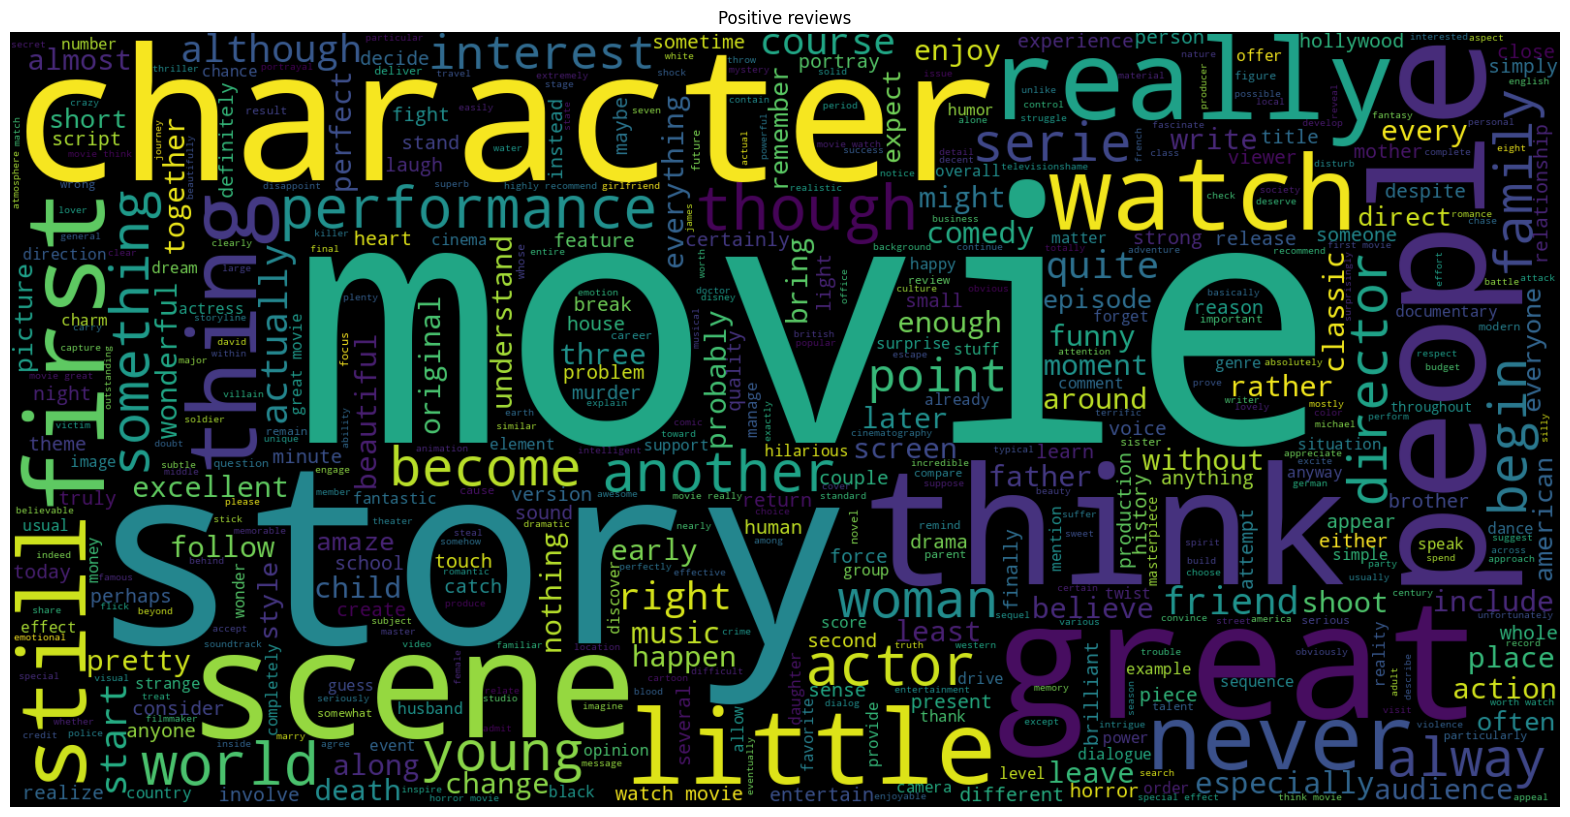

In [ ]:
plt.figure(figsize=(20,20))
Wc=WordCloud(max_words=500,width=1600,height=800,min_word_length=5).generate(" ".join(data[data['sentiment']==1].review))
plt.axis('off')
plt.title('Positive reviews')
plt.imshow(Wc,interpolation='bilinear')

#### Negative reviews

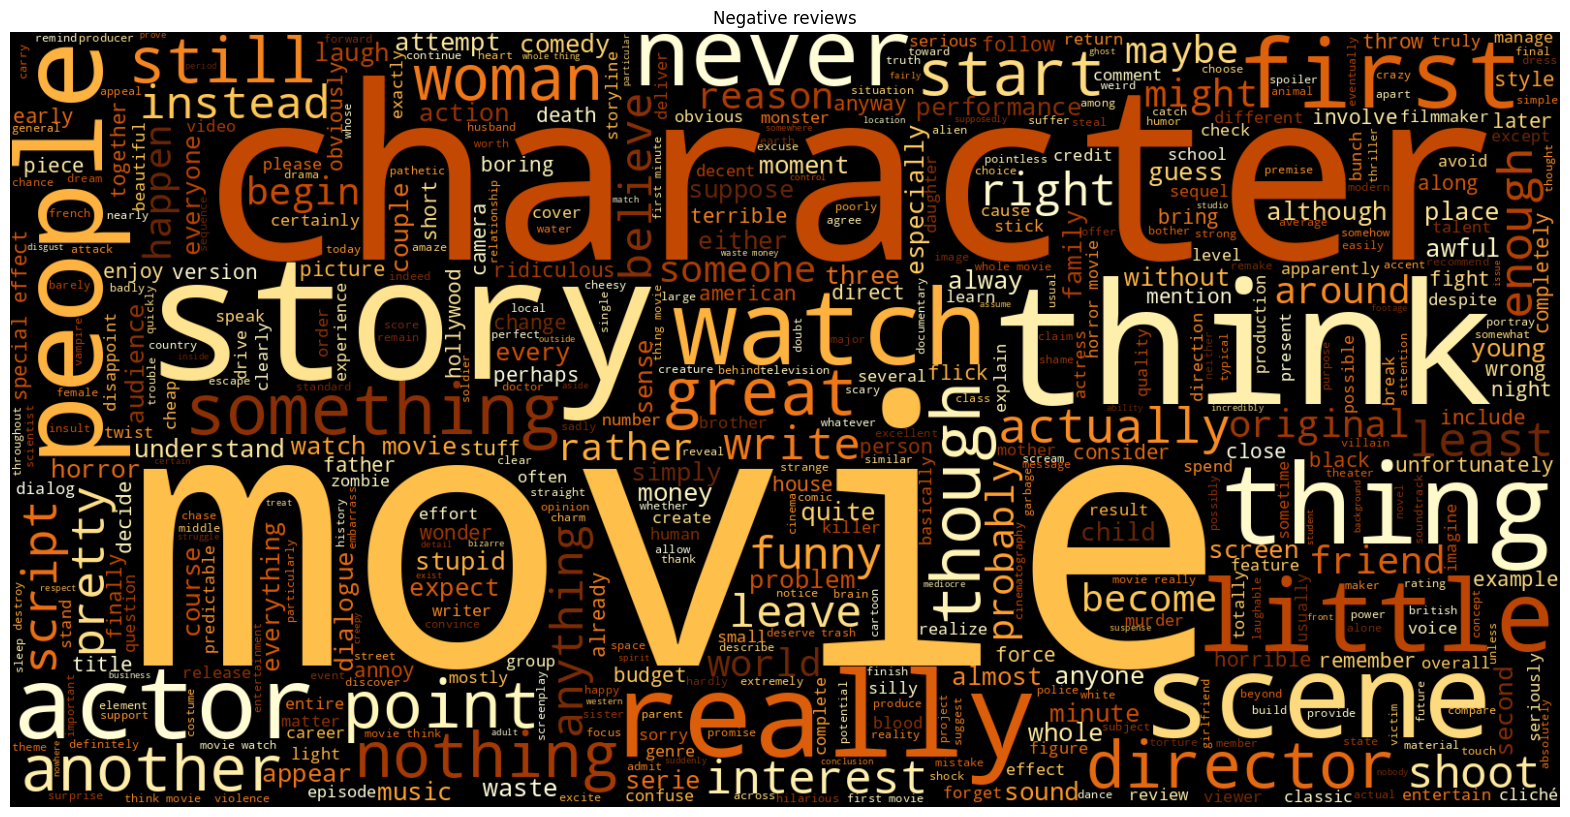

In [ ]:
plt.figure(figsize=(20,20))
Wc=WordCloud(max_words=500,width=1600,height=800,min_word_length=5,colormap='YlOrBr').generate(" ".join(data[data['sentiment']==0].review))
plt.axis('off')
plt.title('Negative reviews')
plt.imshow(Wc,interpolation='bilinear')

## Train-Test split

In [52]:
sentiment=data.sentiment.values
sentiment

array([1, 1, 1, ..., 0, 0, 0])

In [53]:
data1=data.review

In [54]:
x_train,x_test,y_train,y_test=train_test_split(data1,sentiment,test_size=0.2,random_state=42)

## Creating  a Dictionary
**we create a dictionary of 15000 most used words in English for later use**

In [55]:
tokenizer=Tokenizer(num_words=15000)
tokenizer.fit_on_texts(data1)

### Calculating the length of vocabulary

In [56]:
vocabulary_size=len(tokenizer.word_index)+1
vocabulary_size

88197

### converting the text into the integer encoded text

In [57]:
x_train_seq=tokenizer.texts_to_sequences(x_train)
x_test_seq=tokenizer.texts_to_sequences(x_test)

### Taking the word-count/length of each of our sentences in our data and create a list

In [58]:
num_tokens=[len(sentence) for sentence in x_train_seq+x_test_seq]


In [59]:
num_tokens=np.array(num_tokens)

In [60]:
## length of maximum sentence
max(num_tokens)

1296

####Standard deviation tells you how spread out the data is. It is a measure of how far each observed value is from the mean. In any distribution, about 95% of values will be within 2 standard deviations of the mean. Formula is below

In [61]:
max_tokens=np.mean(num_tokens)+2*np.std(num_tokens)
max_tokens=int(max_tokens)
max_tokens

283

#### max_tokens: this value will alow us to reduce the distribution of sentences in our data and the sentenes with opposite lengths, if any, to the avg

In [62]:
## Checking the percentage of the data, this determined number covers
np.sum(num_tokens<max_tokens)/len(num_tokens) #covers 94% of our data

0.94552

### Adjusting the data according to the number of tokens specified

#### Making the input size fixed

In [63]:
x_train_pad=pad_sequences(x_train_seq,maxlen=max_tokens)
x_test_pad=pad_sequences(x_test_seq,maxlen=max_tokens)


In [64]:
x_train_pad.shape

(40000, 283)

In [65]:
x_test_pad.shape

(10000, 283)

## LSTM model

In [122]:
model=Sequential()
model.add(Embedding(input_dim=vocabulary_size,output_dim=100,input_length=max_tokens))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
optimizer=Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 283, 100)          8819700   
                                                                 
 lstm_13 (LSTM)              (None, 64)                42240     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8862005 (33.81 MB)
Trainable params: 8862005 (33.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [123]:
history=model.fit(x_train_pad,y_train,validation_split=0.25,epochs= 10,batch_size=1000,shuffle=True,verbose=1)

Epoch 1/10
30/30 [==============================] - 9s 200ms/step - loss: 0.6428 - accuracy: 0.6834 - val_loss: 0.5297 - val_accuracy: 0.8224
Epoch 2/10
30/30 [==============================] - 5s 155ms/step - loss: 0.3643 - accuracy: 0.8660 - val_loss: 0.3048 - val_accuracy: 0.8750
Epoch 3/10
30/30 [==============================] - 6s 191ms/step - loss: 0.2301 - accuracy: 0.9175 - val_loss: 0.2806 - val_accuracy: 0.8829
Epoch 4/10
30/30 [==============================] - 4s 147ms/step - loss: 0.1693 - accuracy: 0.9440 - val_loss: 0.2887 - val_accuracy: 0.8853
Epoch 5/10
30/30 [==============================] - 4s 114ms/step - loss: 0.1317 - accuracy: 0.9604 - val_loss: 0.3104 - val_accuracy: 0.8808
Epoch 6/10
30/30 [==============================] - 3s 118ms/step - loss: 0.1068 - accuracy: 0.9702 - val_loss: 0.3391 - val_accuracy: 0.8771
Epoch 7/10
30/30 [==============================] - 6s 189ms/step - loss: 0.0898 - accuracy: 0.9764 - val_loss: 0.3823 - val_accuracy: 0.8745
Epoch 

## Result

In [128]:
import numpy as np


x_test_pad = np.array(x_test_pad)
y_test = np.array(y_test)

In [129]:
result=model.evaluate(x_test_pad,y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.4804 - accuracy: 0.8666


## Visualization of Accuracy and Loss

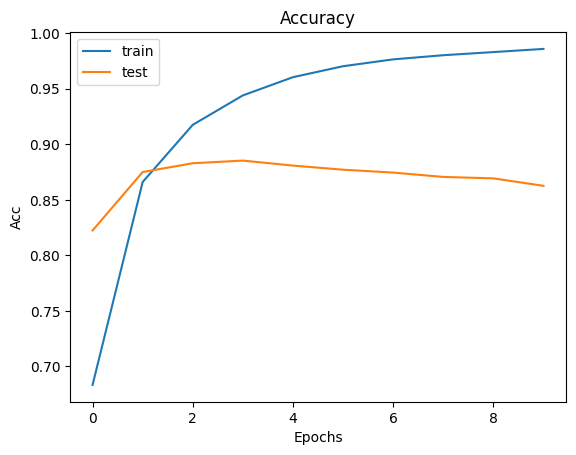

In [130]:
plt.figure()
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("Epochs")
plt.legend()
plt.show()

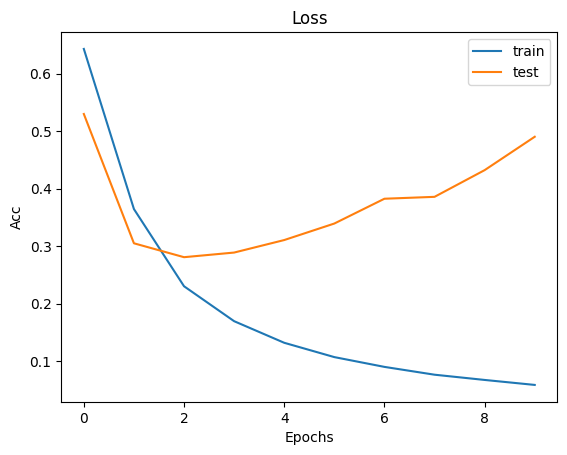

In [131]:
plt.figure()
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [132]:
y_pred=model.predict(x_test_pad)

313/313 [==============================] - 2s 7ms/step


In [133]:
from sklearn.metrics import classification_report,confusion_matrix

## Confusion matrix

In [135]:
y_pred=np.argmax(y_pred,1)

In [136]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [141]:
cm=confusion_matrix(y_test,y_pred)

In [142]:
print("Confusion_matrix:\n",cm)

Confusion_matrix: [[4961    0]
 [5039    0]]


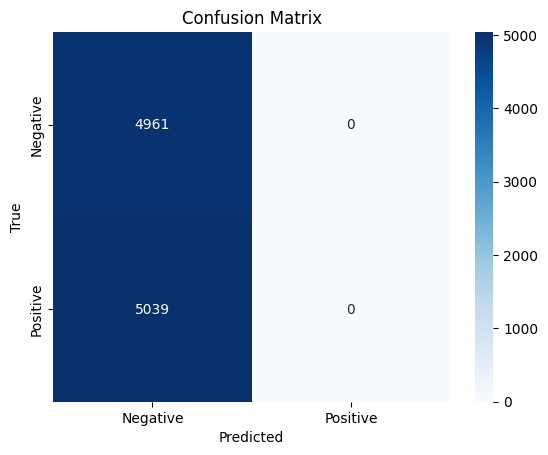

In [144]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [143]:
print("Classification report\n",classification_report(y_test,y_pred))

Classification report
               precision    recall  f1-score   support

           0       0.50      1.00      0.66      4961
           1       0.00      0.00      0.00      5039

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
